<a href="https://colab.research.google.com/github/Gustavo-Martinez-Gutierrez/Gustavo_portfolio/blob/main/5_An%C3%A1lisis_de_Datos_Aplicados_a_la_Gesti%C3%B3n_ML_Supervisado_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

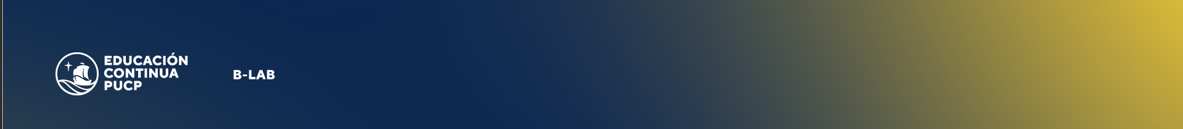

# ML Supervisado - Modelos de Clasificación

Como hemos mencionado en clases anteriores, los modelos de clasificación sirven para poder encontrar una relación entre un target y un conjunto de variables que permita clasificar a un grupo de observaciones en dos o más grupos.

Existen múltiples aplicaciones de los modelos de clasificación. A continuación, algunos ejemplos:
1. Segmentación de clientes: Los modelos de clasificación pueden ayudar a identificar grupos de clientes con características similares. Esto permite a las empresas personalizar estrategias de marketing, promociones y servicios para cada segmento, mejorando la retención y la satisfacción del cliente.
2. Detección de fraude: Los modelos de clasificación se utilizan para identificar patrones y comportamientos sospechosos que podrían indicar fraudes en transacciones financieras, tarjetas de crédito o seguros.
3. Evaluación crediticia: En el sector financiero, los modelos de clasificación se utilizan para evaluar la solvencia crediticia de los clientes.

En esta sesión, abordaremos el siguiente ejemplo:

## Aplicación a Riesgo de Crédito

El objetivo de un banco local es el de crear una herramienta que permita predecir si un cliente que pide una hipoteca va a entrar en default en su préstamo. Para fines de este ejemplo, el cliente entrará en default si ha tenido un atraso de 90 o más días en su préstamo en los siguientes 12 meses luego del otorgamiento del crédito.

Para construir este modelo, se cuenta con información histórica de deudores que accedieron previamente al crédito. De este total, hay algunos que han entrado en default y otros que no lo han hecho. Además, para este grupo, tenemos información previa de una serie de features que describen a estos clientes.

Dado que el objetivo es predecir la probabilidad de default, podemos reformular el problema como el de clasificar a los clientes en dos grupos: "buenos" (no default) y "malos" (default), lo que nos lleva a plantear un modelo de clasificación. Existen diversos métodos para poder abordar este problema, de los que veremos únicamente tres:
- Regresión logística.
- Árboles de clasificación.
- Modelos de ensamblado.

Antes de estimar los modelos, vamos a definir cómo los vamos a evaluar. En particular, existen varias métricas como el AUC, el Gini, pero también tenemos otras métricas construidas a partir de la matriz de confusión, como son la precisión, el recall y el F1.

### *Precisión, Recall y F1:*

Recordemos que la precisión se mide como la proporción de valores positivos predichos que son *realmente* positivos:
\begin{align}
        \text{Precision} = \frac{TP}{TP+FP}
    \end{align}
donde TP significa "True Positive" y FP significa "False Positive". Por otro lado, el recall indica la proporción de casoa *realmente* positivos que son clasificados correctamente como positivos:
\begin{align}
        \text{Recall} = \frac{TP}{TP+FN}
    \end{align}
donde FN significa "False Negative". Finalmente, el F1 es igual a la media armónica entre la precisión y el recall.
\begin{align}
        \text{F1} = 2*\frac{\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}}
    \end{align}
En general, un "buen" modelo debería presentar valores elevados de precisión, recall y F1. Sin embargo, existe un trade off entre precisión y recall, por lo que la elección de una u otra métrica dependerá del contexto.
La mejor manera de equilibrar la precisión y el recall depende de la aplicación específica. Por ejemplo, si es importante minimizar los falsos positivos, la precisión es una métrica más importante. Si es importante minimizar los falsos negativos, el recall es una métrica más importante.


### 1. Preliminares:

La estimación de modelos de clasificación en general, y de riesgo de crédito en particular, implican el uso de varias librerías.

In [ ]:
import IPython
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import scipy
import scipy.stats as stats
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [ ]:
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, r2_score, make_scorer, mean_squared_error, mean_absolute_error,roc_curve,accuracy_score,roc_auc_score,brier_score_loss, precision_score, recall_score,precision_recall_curve, f1_score, log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler

In [ ]:
pd.options.display.max_columns=100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Importamos una matriz de datos preprocesados (con todos los features ya creados y el target). Previamente hemos separado las muestras en entrenamiento y validación:
data_train = pd.read_csv("/content/drive/MyDrive/data_train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/data_test.csv")

# Nos quedamos con las variables X para estandarizarlas:
X_train = data_train.drop(['default_time', 'time'], axis=1)
X_test = data_test.drop(['default_time', 'time'], axis=1)

# Una estrategia para poder tener un mejor modelo pasa por estandarizar los datos:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Nos quedamos con los target. La función .reshape(-1,) convierte el objeto NumPy
# en un vector de una dimensión.
y_train = data_train['default_time'].values.reshape(-1,)
y_test = data_test['default_time'].values.reshape(-1,)

In [ ]:
X_train.head()

,cep_time,equity_time,interest_rate_time,FICO_orig_time,gdp_time,PCA1_1,PCA2_1,PCA3_1,PCA4_1,PCA5_1
0,-0.002785,0.660890,10.50,587,2.899137,-0.104556,0.523194,-0.23227,-0.506923,0.062275
1,-0.005303,0.343575,8.73,501,2.899137,-0.104556,0.523194,-0.23227,-0.506923,0.062275
2,-0.002281,0.332062,6.93,600,2.899137,-0.104556,0.523194,-0.23227,-0.506923,0.062275
3,-0.002755,0.347885,7.56,635,2.899137,-0.104556,0.523194,-0.23227,-0.506923,0.062275
4,-0.002243,0.331895,7.03,584,2.899137,-0.104556,0.523194,-0.23227,-0.506923,0.062275


### 2. Regresión Logística

En este caso usaremos la librería scikit-learn. El proceso consta principalmente de tres etapas:
1. Seleccionar el modelo como un objeto, llamado "estimador" en scikit-learn.
2. Estimar el modelo.
3. Calcular predicciones y validar el modelo.

In [ ]:
model_lr = LogisticRegression(penalty=None, fit_intercept=True, solver='saga', tol=1e-15,  max_iter=15000)
model_lr.fit(X_train_scaled, y_train)

print('Coeficientes:', model_lr.coef_.round(decimals=4))
print('Intercepto:', model_lr.intercept_.round(decimals=4))

Coeficientes: [[-0.2827 -0.2594  0.3023 -0.796   0.0445 -0.0583  0.0091  0.0558 -0.0807
  -0.0613]]
Intercepto: [-5.0959]


Calculamos las predicciones y los resultados de validación dentro de la muestra. Esto tiene un fin meramente pedagógico en tanto los resultados de la validación solo se deben examinar cuando se utiliza la muestra de validación.

In [ ]:
predictions_train = model_lr.predict_proba(X_train_scaled)[:,1].T
predictions_train_1 = model_lr.predict(X_train_scaled)

**Indicadores de Bondad Predictiva**
Los indicadores que analizaremos en este caso son los siguientes:
- Diferencia entre PD y RD
- AUC
- Gini
- RMSE / Brier Score
- Matriz de Confusión
- F1


In [ ]:
rd = (sum(y_train)/len(y_train)).round(4)
pd = np.mean(predictions_train).round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))

RD: 0.0104
PD: 0.0104


In [ ]:
roc_auc = roc_auc_score(y_train, predictions_train).round(4)
gini = (2*roc_auc-1).round(4)

print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))

AUC: 0.7834
Gini: 0.5668


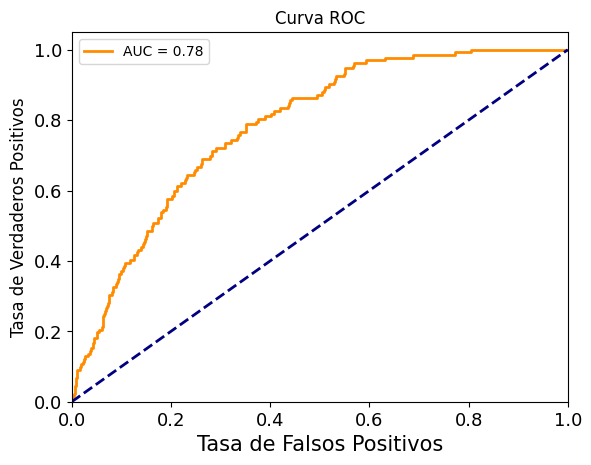

In [ ]:
# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_train, predictions_train)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')

Text(0.5, 1.0, 'Matriz de Confusión')

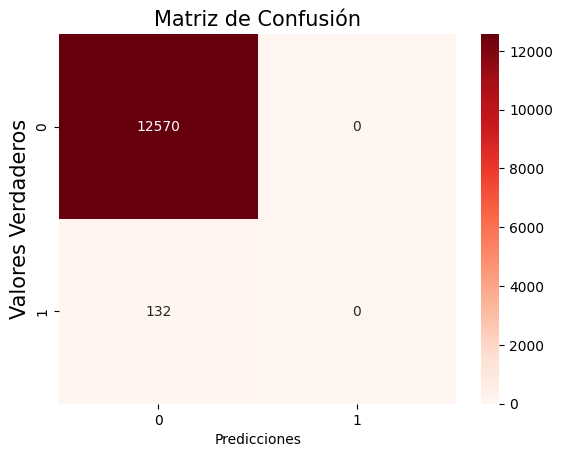

In [ ]:
confusion = confusion_matrix(y_train, predictions_train_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

In [ ]:
f1 = f1_score(y_train, predictions_train_1, average='weighted').round(4)
print("F1 Score: {:.4f}".format(f1))

F1 Score: 0.9844


La evaluación del performance del modelo se analiza sobre la muestra de validación

In [ ]:
predictions_test = model_lr.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_lr.predict(X_test_scaled)

In [ ]:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))

RD: 0.0289
PD: 0.0102


In [ ]:
roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))

AUC: 0.6465
Gini: 0.2930


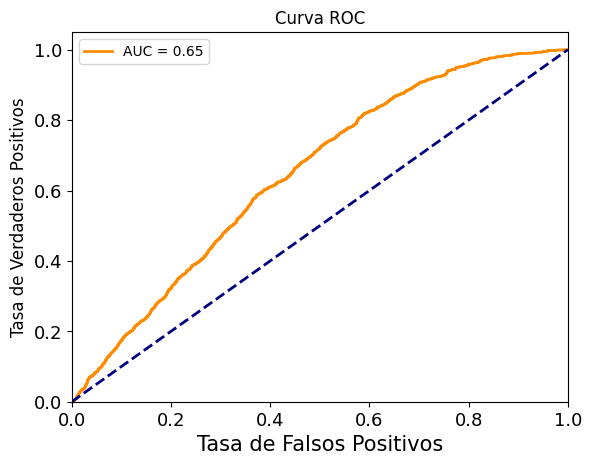

In [ ]:
# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')

Text(0.5, 1.0, 'Matriz de Confusión')

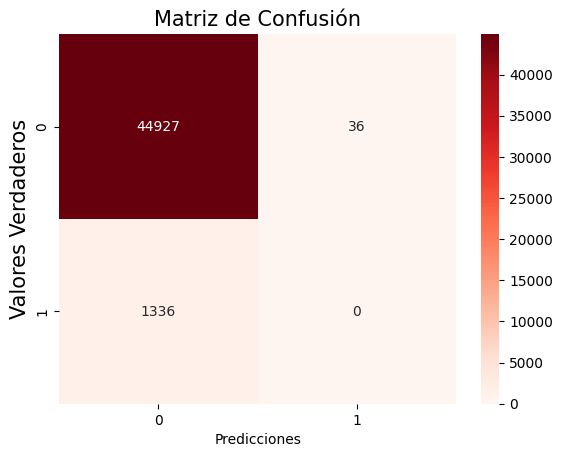

In [ ]:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

In [ ]:
f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)
print("F1 Score: {:.4f}".format(f1))

F1 Score: 0.9565


### ¿Qué ocurre con la matriz de confusión?

En esta base de datos, al ser información de créditos hipotecarios, tiene un claro desbalance ya que la probabilidad de default es de aproximadamente 1%. En estos casos, podemos modificar el umbral al partir del cual se considera un caso positivo para que la matriz de confusión pueda clasificar mejor.

Es importante señalar que este umbral tiene que aplicarse tanto a los datos de entrenamiento como los de validación, así como a cualquier indicador que dependa de esta matriz, como el F1.

Por otro lado, si se cuenta con una clasificación desbalanceada, existen otros métodos como el sobremuestreo o la obtención de muestras sintéticas.

Así, para el caso de la muestra de entrenamiento tenemos que:

In [ ]:
# Fijamos un umbral determinado, que se puede modificar:
umbral = 0.03

# Asignar la clase basada en el umbral
predictions_train_mod_1 = (predictions_train > umbral).astype(int)

Text(0.5, 1.0, 'Matriz de Confusión')

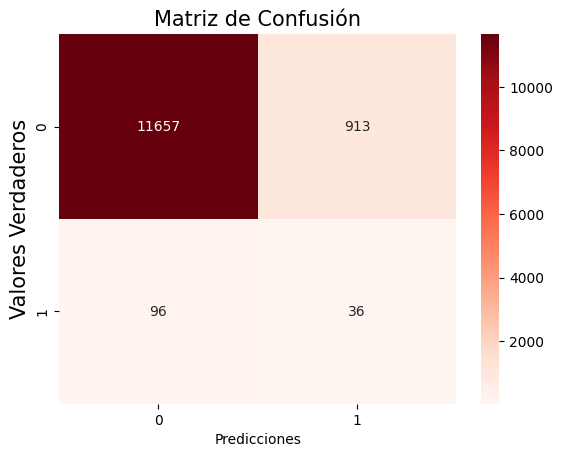

In [ ]:
confusion = confusion_matrix(y_train, predictions_train_mod_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

In [ ]:
f1 = f1_score(y_train, predictions_train_mod_1, average='weighted').round(4)
print("F1 Score: {:.4f}".format(f1))

F1 Score: 0.9492


Mientras que para la muestra de validación:

In [ ]:
# Asignar la clase basada en el umbral:
predictions_test_mod_1 = (predictions_test > umbral).astype(int)

Text(0.5, 1.0, 'Matriz de Confusión')

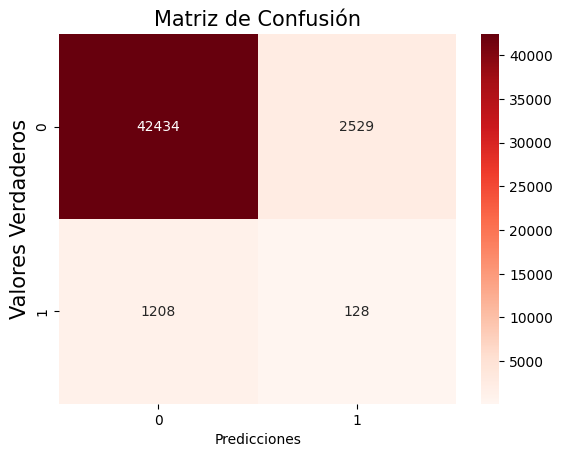

In [ ]:
confusion = confusion_matrix(y_test, predictions_test_mod_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

In [ ]:
f1 = f1_score(y_test, predictions_test_mod_1, average='weighted').round(4)
print("F1 Score: {:.4f}".format(f1))

F1 Score: 0.9320


### 3. Árbol de Clasificación

Algunos parámetros del árbol a tomar en cuenta (y que pueden ser optimizados mediante VC):
- max_depth: controla la profundidad máxima del árbol. Un árbol más profundo será más complejo y puede aprender patrones más complejos, pero también puede tener problemas de sobreajuste.
- max_features: Controla el número máximo de features a considerar cuando se parte un nodo. Un número más alto puede dar más flexibilidad de aprender patrones más complejos en la data, pero puede generar sobreajuste.
- min_samples_split: Controla el número mínimo de muestras necesarias para dividir un nodo. Un valor más alto evitará que el árbol se divida en datos pequeños o ruidosos, pero también puede provocar un ajuste insuficiente.
- min_samples_leaf: Controla el número mínimo de muestras requeridas en un nodo hoja. Un valor más alto evitará que el árbol aprenda de subconjuntos de datos pequeños o ruidosos, pero también puede provocar un ajuste insuficiente (*underfitting*).

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=12345, max_depth=6, max_features=3)
model_dt.fit(X_train_scaled, y_train)

print(model_dt.feature_importances_.round(4))

[0.1885 0.2397 0.1097 0.286  0.0746 0.0355 0.0042 0.0342 0.0045 0.0232]


In [ ]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=5, max_features=5)
model_dt.fit(X_train_scaled, y_train)

print(model_dt.feature_importances_.round(4))

[0.3411 0.218  0.2154 0.0849 0.1291 0.0115 0.     0.     0.     0.    ]


In [ ]:
predictions_train = model_dt.predict_proba(X_train_scaled)[:,1].T
predictions_train_1 = model_dt.predict(X_train_scaled)

In [ ]:
rd = (sum(y_train)/len(y_train)).round(4)
pd = np.mean(predictions_train).round(4)

roc_auc = roc_auc_score(y_train, predictions_train).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_train, predictions_train_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

RD: 0.0104
PD: 0.0104
AUC: 0.8463
Gini: 0.6926
F1 Score: 0.9865


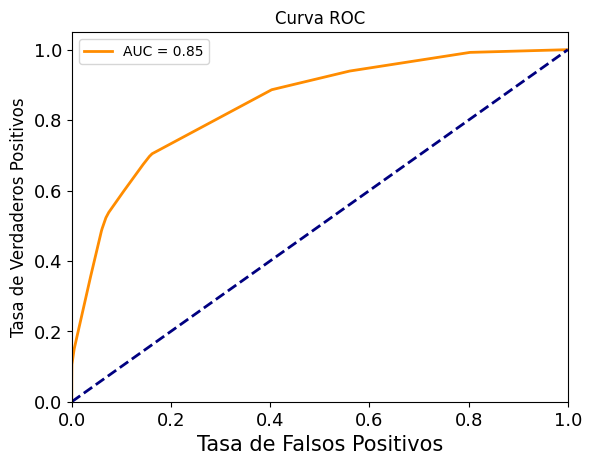

In [ ]:
# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_train, predictions_train)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')

Text(0.5, 1.0, 'Matriz de Confusión')

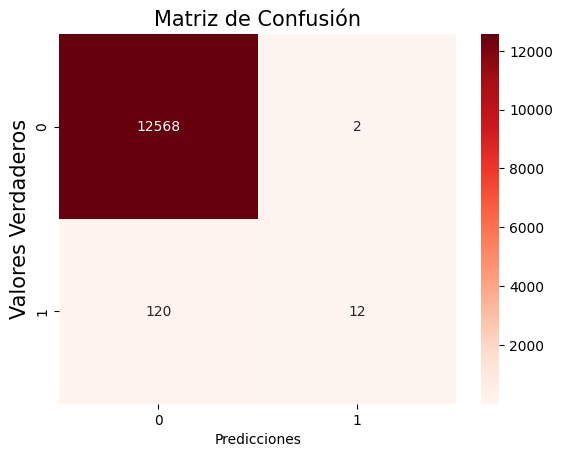

In [ ]:
confusion = confusion_matrix(y_train, predictions_train_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

In [ ]:
predictions_test = model_dt.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_dt.predict(X_test_scaled)

In [ ]:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

RD: 0.0289
PD: 0.0706
AUC: 0.6480
Gini: 0.2960
F1 Score: 0.9317


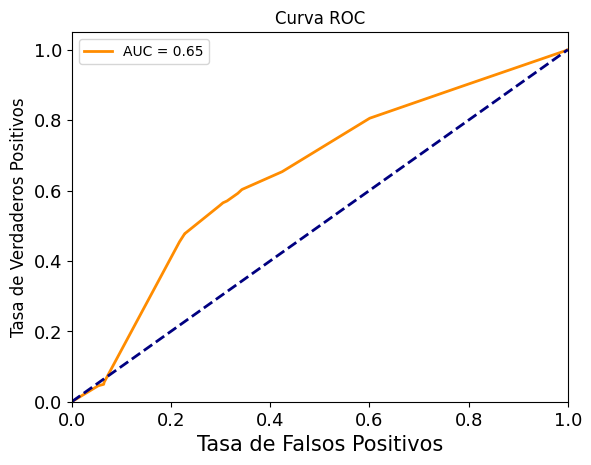

In [ ]:
# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')

Text(0.5, 1.0, 'Matriz de Confusión')

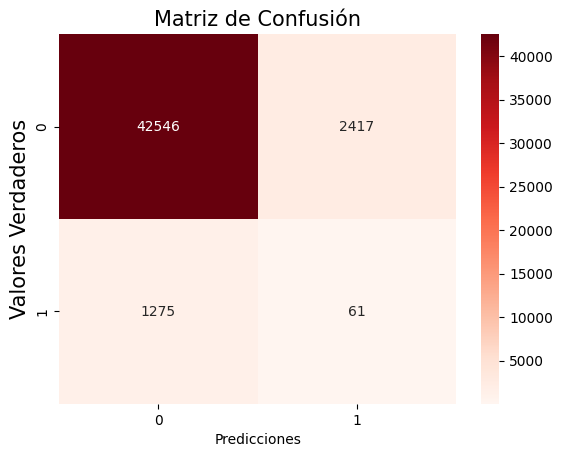

In [ ]:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

#### 3.1. Árbol de Clasificación con optimización de hiperparámetros

Al igual que en el caso anterior, la profundidad y el número máximo de features que deben incluirse en el árbol son hiperparámetros que pueden optimizarse. Para ello, recurrimos al método de validación cruzada.

La validación cruzada es una técnica utilizada en machine learning para evaluar el rendimiento de un modelo de manera más confiable. En lugar de dividir el conjunto de datos en solo dos partes (entrenamiento y validación), la validación cruzada divide los datos de entrenamiento en múltiples conjuntos más pequeños llamados "pliegues" o "folds".

El proceso de validación cruzada implica:

* Dividir el conjunto de datos en K pliegues (por ejemplo, K = 5 o K = 10).
* Entrenar el modelo K veces, utilizando un pliegue diferente como conjunto de prueba en cada iteración y los demás pliegues como conjunto de entrenamiento.
* Calcular el rendimiento del modelo en cada iteración.
* Calcular el rendimiento promedio y la varianza de esos rendimientos.

La principal ventaja de la validación cruzada es que proporciona una evaluación más robusta del rendimiento del modelo, ya que utiliza múltiples divisiones de los datos.

In [ ]:
params_dt = {'max_depth': np.arange(2,10,1),  'max_features': np.arange(2,10,1)}
model_dt = DecisionTreeClassifier(random_state=12345)

gs_dt = GridSearchCV(model_dt, params_dt, verbose=1, n_jobs=2, cv=5, scoring='roc_auc')
gs_dt.fit(X_train_scaled, y_train)

print(gs_dt.best_params_)

filename = 'Mortgage_dt_GridSearch.sav'
pickle.dump(gs_dt, open(filename, 'wb'))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'max_depth': 4, 'max_features': 6}


In [ ]:
print(cross_val_score(model_dt, X_train_scaled, y_train, cv=5, scoring='roc_auc'))

[0.52768938 0.53087156 0.45774432 0.54655468 0.52530445]


Utilizando este método, se seleccionan los valores óptimos de max_depth y max_features. Esos valores se emplean para reentrenar el modelo:

In [ ]:
filename = 'Mortgage_dt_GridSearch.sav'
gs_dt = pickle.load(open(filename, 'rb'))

model_dt_best = DecisionTreeClassifier(random_state=12345, max_depth = gs_dt.best_params_.get('max_depth'),  max_features = gs_dt.best_params_.get('max_features'))
model_dt_best.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=4, max_features=6, random_state=12345)

In [ ]:
print(cross_val_score(model_dt_best, X_train_scaled, y_train, cv=5, scoring='roc_auc'))

[0.79808627 0.7075562  0.58386115 0.81622912 0.53362707]


In [ ]:
predictions_test = model_dt_best.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_dt_best.predict(X_test_scaled)

In [ ]:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

RD: 0.0289
PD: 0.0483
AUC: 0.6422
Gini: 0.2844
F1 Score: 0.9419


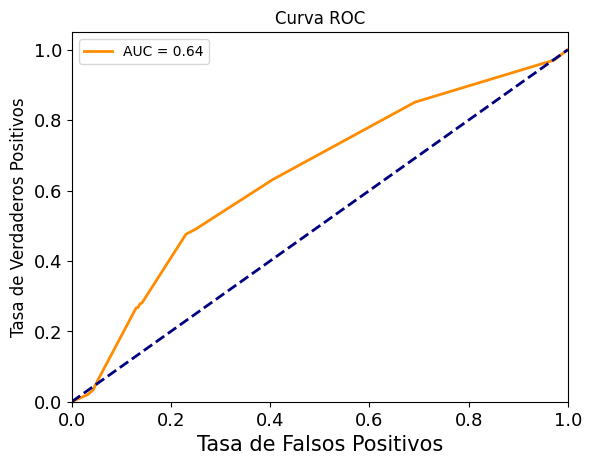

In [ ]:
# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')

Text(0.5, 1.0, 'Matriz de Confusión')

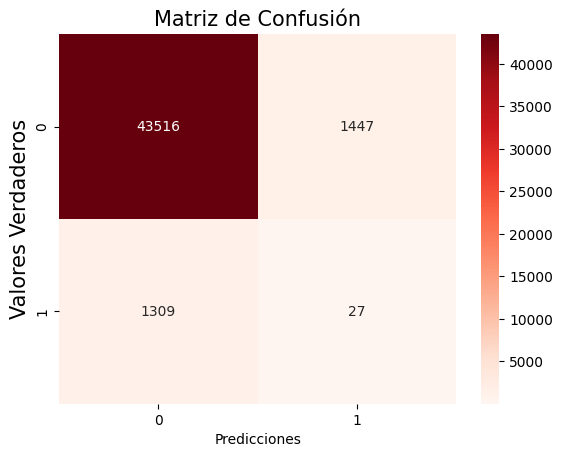

In [ ]:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)

#### 3.2. Visualización de árboles

Una de las principales ventajas de los modelos de árboles de clasificación es que permiten una interpertación gráfica. Sin embargo, para poder realizarla, es necesario interpretar el gráfico:
- En cada uno de los nodos se puede apreciar el valor de la variable que lo determina y el punto de corte correspondiente.
- También está el número de observaciones en cada nodo, pero también el número de observaciones que pertenece a cada una de las categorías.
- Finalmente, está el coeficiente de Gini. Este Gini está relacionado con el de un modelo de clasificación, pero no es exactamente el mismo. En este caso, el Gini refleja la "impureza" de los datos, es decir, si cada nodo concentra observaciones correspondientes a una sola categoría. En este sentido, un coeficiente de impureza de Gini es mejor mientras más cercano sea igual a cero, en el sentido que cada nodo cumple con su labor de separar a las distintas categorías.
- Existen otras métricas de clasificación como la de entropía.

(**Nota**: El Gini que habitualmente reportamos se refiere a la habilidad de que un modelo con un set de varios features cumple con su función de clasificar, mientras que el Gini al que ahora nos referimos se refiere a la capacidad de clasificación de una sola variable).

In [ ]:
# model_dt_train = DecisionTreeClassifier(random_state=12345, max_depth=4, max_features=6, min_samples_leaf=5)
model_dt_train = DecisionTreeClassifier(random_state=12345, max_depth=3, max_features=6)
model_dt_train.fit(X_train, y_train)

print(model_dt_train.feature_importances_.round(4))

[0.2992 0.     0.426  0.1435 0.     0.     0.     0.1314 0.     0.    ]


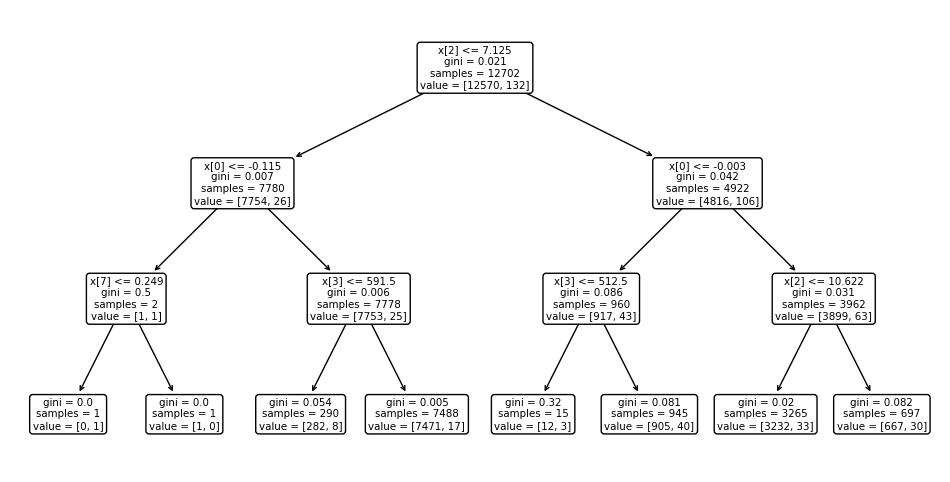

In [ ]:
from sklearn import tree

plt.figure(figsize=(12, 6))
tree.plot_tree(model_dt_train, rounded=True)
plt.show()

#### 3.3. Tips para el uso de árboles de clasificación

1. Los árboles de decisión tienden a sobreajustar con datos con un elevado número de *features*.
2. Es recomendable usar alguna técnica de reducción de dimensionalidad o una técnica de selección de *features* para maximizar la probabilidad de encontrar un árbol con capacidad de discriminar.
3. Es importante entender la estructura del árbol. Esto permitirá conocer cuáles son los criterios utilizados para construirlo y ver si tienen sentido económico más allá del algoritmo utilizado.
4. Visualizar el árbol cada vez que se entrene: se puede comenzar con una profundidad de 2 o 3 y luego ir incrementando la complejidad.
5. Asegurar que no queden pocas observaciones en los nodos finales, eso es signo de sobreajuste.
6. Los algoritmos funcionan mejor con datos balanceados.

### 4.Modelos de ensamblado

Las técnicas que hemos visto hasta ahora son técnicas *stand-alone*. La principal característica de estos métodos es que se estiman y dan resultados una vez que son iniciados. Por ejemplo, especificamos una regresión logística y luego se ven los resultados. Una extensión de este enfoque es el de validación cruzada, que involucra múltiples estimaciones. No obstante, la optimización de hiperparámetros se realiza tomando como fija una sola clase de modelos. Luego de este procedimiento, el modelo se estima una única vez con toda la muestra de entrenamiento.
Los modelos de ensamblado estiman un solo modelo mútiples veces utilizando muestras seleccionadas mediante *bootstrap* y luego agregan los resultados. Es decir, construimos una predicción a partir de varios modelos base. Aquí se promedian varios modelos insesgados pero que incorporan un componente de ruido y como resultado se reduce la varianza.
Una particularidad de los modelos de ensamblado es que permiten combinar resultados de diferentes métodos como la regresión logística, árboles de clasificación, redes neuronales y luego construyen una predicción combinada ("ensamblada").
Un método popular de bootstrap es el Bagging. Otro es el de votación.

#### 4.1. Bagging

Bagging o Bootstrap Aggregating (Breiman, 1996) pertenece a los métodos de ensamblado. Se ajusta un modelo determinado varias veces utilizando muestras de datos seleccionadas por bootstrap y se agregan los resultados.

In [ ]:
from sklearn.ensemble import BaggingClassifier

lr_bag = LogisticRegression(penalty='none', fit_intercept=True, solver='saga', tol=1e-15,  max_iter=1000)

model_lr_bag=BaggingClassifier(lr_bag, n_estimators=20, max_samples=0.8, max_features=1.0,  bootstrap=True, warm_start=False, n_jobs=2, oob_score=True, random_state=12345, verbose=2)
model_lr_bag.fit(X_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   24.4s finished


BaggingClassifier(estimator=LogisticRegression(max_iter=1000, penalty='none',
                                               solver='saga', tol=1e-15),
                  max_samples=0.8, n_estimators=20, n_jobs=2, oob_score=True,
                  random_state=12345, verbose=2)

Luego procedemos a evaluar el modelo con las herramientas vistas en clases
anteriores (por temas de brevedad vamos a evaluar el modelo únicamente en la muestra de validación):

In [ ]:
predictions_test = model_lr_bag.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_lr_bag.predict(X_test_scaled)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished


RD: 0.0289
PD: 0.0411
AUC: 0.6738
Gini: 0.3476
F1 Score: 0.9566


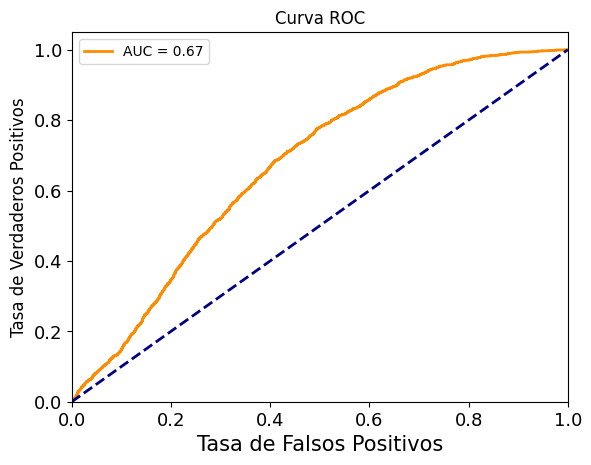

In [ ]:
# Indicadores de bondad predictiva:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')
plt.show()

# Matriz de confusión:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

#### 4.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(random_state=12345, max_depth=5, warm_start=False,  n_estimators=200)
model_rfc.fit(X_train_scaled, y_train)

print(model_rfc.feature_importances_.round(decimals=4))

[0.2399 0.1948 0.1869 0.2141 0.0453 0.0252 0.0268 0.0153 0.0261 0.0256]


In [ ]:
predictions_test = model_rfc.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_rfc.predict(X_test_scaled)

RD: 0.0289
PD: 0.0611
AUC: 0.6594
Gini: 0.3188
F1 Score: 0.9569


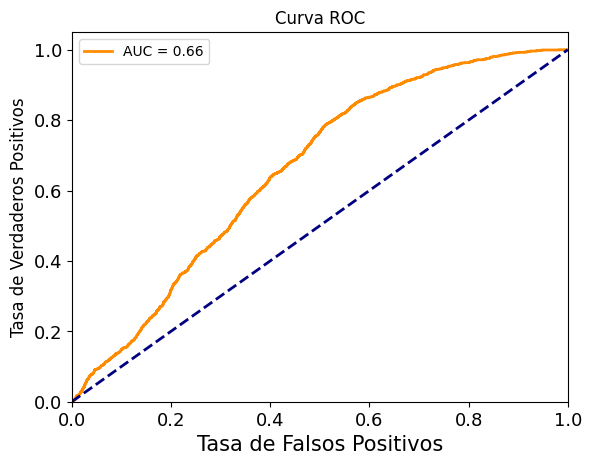

In [ ]:
# Indicadores de bondad predictiva:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')
plt.show()

# Matriz de confusión:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

#### RF - Optimización de Hiperparámetros

Al igual que en los métodos stand-alone, se puede proceder a optimizar los hiperparámetros mediante validación cruzada. Aplicaremos una búsqueda aleatoria a través de la malla de posibles valores con un máximo de 50 iteraciones. Depenidendo de la complejidad del modelo (número de observaciones, de features y de iteraciones) el proceso puede ser bastante largo.

In [ ]:
# Nota: En este caso el procedimiento tarda 8 min.
params_rfc = {
    'n_estimators': sp_randint(1, 500),
    'max_depth': [2, 3, 4, 5, 10, None],
    'max_features': sp_randint(1, 10),
    'min_samples_split': sp_randint(2, 11)}

model_rfc = RandomForestClassifier(random_state=12345)
rs_rfc = RandomizedSearchCV(model_rfc, params_rfc, verbose=1, n_iter=50, n_jobs=4, cv=5,  random_state=12345, scoring='roc_auc')
rs_rfc.fit(X_train_scaled, y_train)

print(rs_rfc.best_params_)

filename = 'Mortgage_rfc_RandomizedGridSearch.sav'
pickle.dump(rs_rfc, open(filename, 'wb'))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'max_depth': 2, 'max_features': 6, 'min_samples_split': 8, 'n_estimators': 13}


Luego del proceso de optimización, se procede a estimar el modelo (con la muestra de entrenamiento) y finalmente a evaluar los indicadores de ajuste (con la muestra de validación).

In [ ]:
filename = 'Mortgage_rfc_RandomizedGridSearch.sav'
rs_rfc = pickle.load(open(filename, 'rb'))

print(rs_rfc.best_params_)

#np.random.seed(seed=12345)

model_rfc_best=RandomForestClassifier(random_state=12345,
                                      max_depth = rs_rfc.best_params_.get('max_depth'),
                                      max_features = rs_rfc.best_params_.get('max_features'),
                                      min_samples_split = rs_rfc.best_params_.get('min_samples_split'),
                                      n_estimators = rs_rfc.best_params_.get('n_estimators'))
model_rfc_best.fit(X_train_scaled, y_train)

print(model_rfc_best.feature_importances_.round(decimals=4))

{'max_depth': 2, 'max_features': 6, 'min_samples_split': 8, 'n_estimators': 13}
[0.2092 0.0545 0.3356 0.3015 0.0304 0.0029 0.     0.     0.     0.0659]


In [ ]:
predictions_train = model_rfc_best.predict_proba(X_train_scaled)[:,1].T
predictions_train_1 = model_rfc_best.predict(X_train_scaled)

RD: 0.0104
PD: 0.0104
AUC: 0.8148
Gini: 0.6296
F1 Score: 0.9844


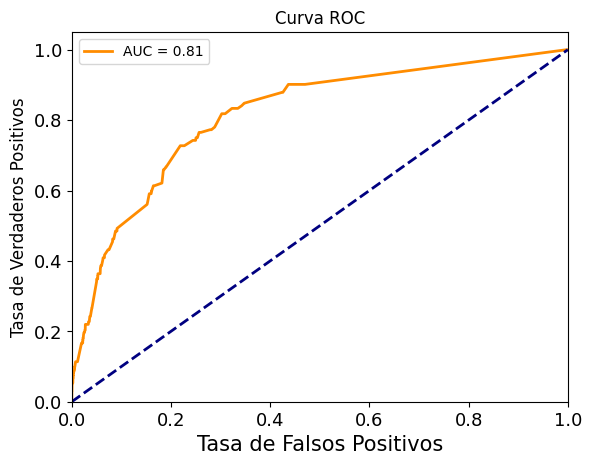

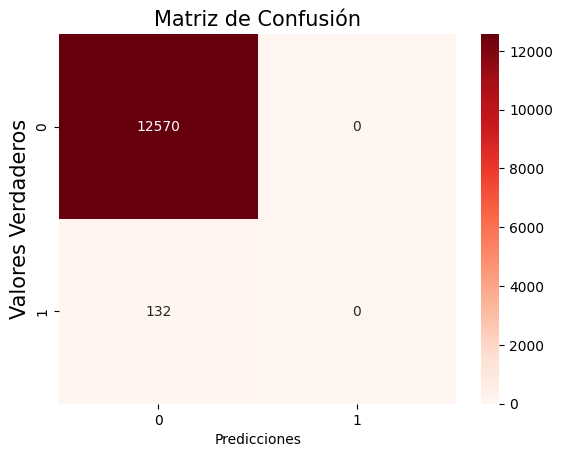

In [ ]:
# Indicadores de bondad predictiva:
rd = (sum(y_train)/len(y_train)).round(4)
pd = np.mean(predictions_train).round(4)

roc_auc = roc_auc_score(y_train, predictions_train).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_train, predictions_train_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_train, predictions_train)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')
plt.show()

# Matriz de confusión:
confusion = confusion_matrix(y_train, predictions_train_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

In [ ]:
predictions_test = model_rfc_best.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_rfc_best.predict(X_test_scaled)

RD: 0.0289
PD: 0.0234
AUC: 0.6204
Gini: 0.2408
F1 Score: 0.9569


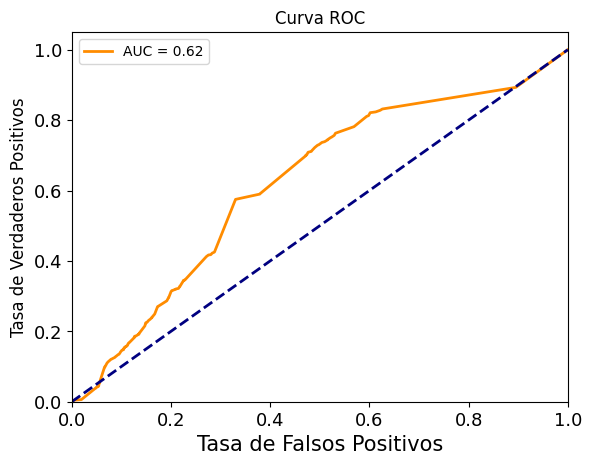

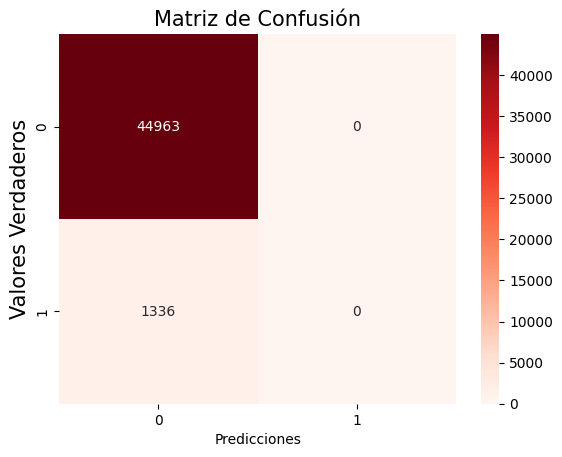

In [ ]:
# Indicadores de bondad predictiva:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')
plt.show()

# Matriz de confusión:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

#### 4.3. Boosting

El boosting también es un método de ensamblado. En nuestro contexto, la idea general es tener un clasificador débil, que es un método con unperformance (por ejemplo, discriminación) ligeramente mejor que un modelo aleatorio, y combinar muchos de ellos mejorándolos progresivamente. En otras palabras, entrenamos los modelos secuencialmente y con ello se tratan de mejorar los predecesores.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_dt_grboost = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100,
                                              subsample=0.5, random_state=12345, max_features=None,
                                              verbose=0)
model_dt_grboost.fit(X_train_scaled, y_train)

print(model_dt_grboost.feature_importances_)

[0.30309467 0.2047649  0.15866685 0.18673661 0.07411772 0.02343973
 0.00886695 0.00617343 0.01405821 0.02008093]


Evaluamos el modelo sobre la muestra de entrenamiento:

In [ ]:
predictions_train = model_dt_grboost.predict_proba(X_train_scaled)[:,1].T
predictions_train_1 = model_dt_grboost.predict(X_train_scaled)

RD: 0.0104
PD: 0.0104
AUC: 0.8937
Gini: 0.7874
F1 Score: 0.9844


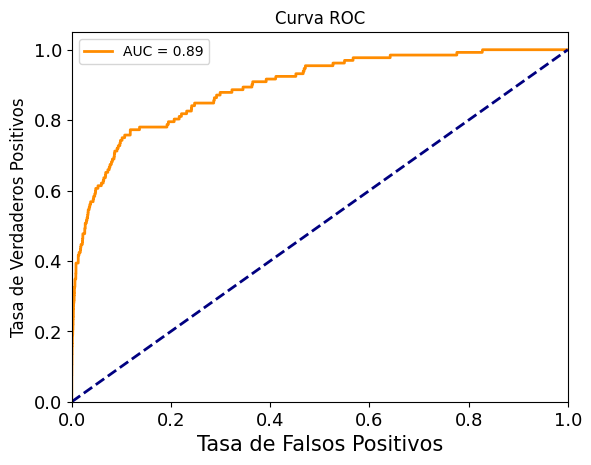

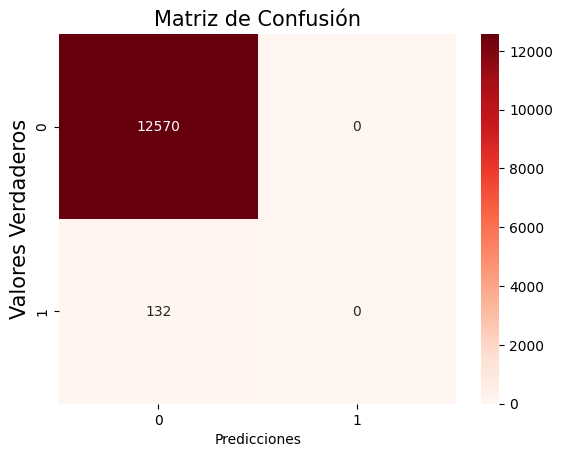

In [ ]:
# Indicadores de bondad predictiva:
rd = (sum(y_train)/len(y_train)).round(4)
pd = np.mean(predictions_train).round(4)

roc_auc = roc_auc_score(y_train, predictions_train).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_train, predictions_train_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_train, predictions_train)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')
plt.show()

# Matriz de confusión:
confusion = confusion_matrix(y_train, predictions_train_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

Evaluamos el modelo sobre la muestra de validación:

In [ ]:
predictions_test = model_dt_grboost.predict_proba(X_test_scaled)[:,1].T
predictions_test_1 = model_dt_grboost.predict(X_test_scaled)

RD: 0.0289
PD: 0.0747
AUC: 0.6593
Gini: 0.3186
F1 Score: 0.9450


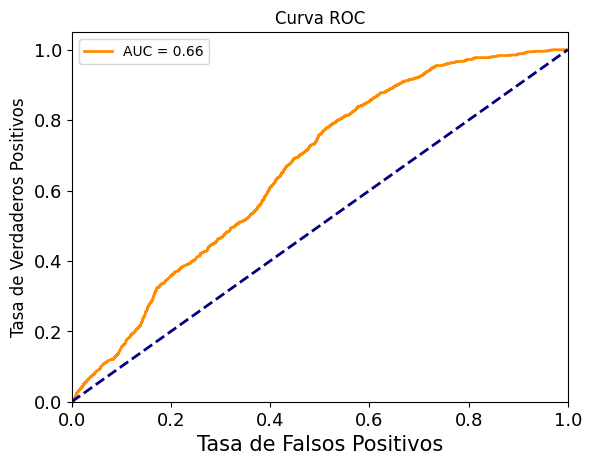

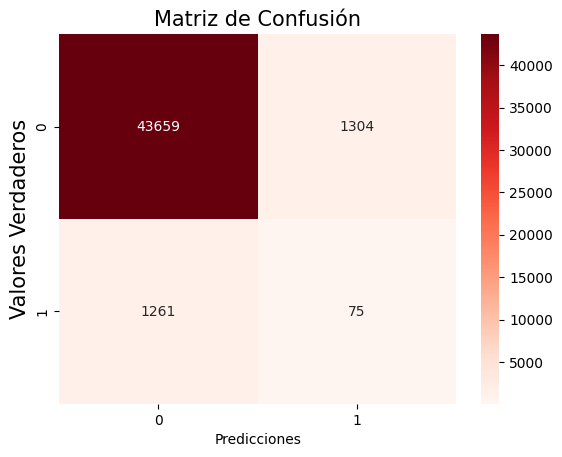

In [ ]:
# Indicadores de bondad predictiva:
rd = (sum(y_test)/len(y_test)).round(4)
pd = np.mean(predictions_test).round(4)

roc_auc = roc_auc_score(y_test, predictions_test).round(4)
gini = (2*roc_auc-1).round(4)

f1 = f1_score(y_test, predictions_test_1, average='weighted').round(4)

print("RD: {:.4f}".format(rd))
print("PD: {:.4f}".format(pd))
print("AUC: {:.4f}".format(roc_auc))
print("Gini: {:.4f}".format(gini))
print("F1 Score: {:.4f}".format(f1))

# Curva ROC:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)

plt.title('Curva ROC')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(loc='best')
plt.show()

# Matriz de confusión:
confusion = confusion_matrix(y_test, predictions_test_1)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos', fontsize=15)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()